In [1]:
from google.colab import drive
from pathlib import Path
import scipy.io
from glob import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import pandas as pd
from sklearn.preprocessing import normalize, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.stats import zscore

In [2]:
drive.mount('/content/drive')

MessageError: ignored

#1. Aquisição dos Dados

In [ ]:
data = Path('drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/data')

signals = []
classes =[]

for value in sorted(data.glob('*.mat')):
  signal = scipy.io.loadmat(value)
  signal = np.array(signal["val"], dtype='float')[0]
  signals.append(signal)
  # print(value)

In [ ]:
classification_path = os.path.join(data, "classification.txt")
with open(classification_path) as f:
    classes = f.readlines()

for i in range(0, len(classes)):
  classes[i] = classes[i][classes[i].find(','):]
  classes[i] = classes[i][: classes[i].find('\n')]
  classes[i] = classes[i].replace(",", "")

# classes = classes[0: -1]

#2. Preprocessamento

### 2.1 Análise da distribuição das classes

In [ ]:
d = {'signals': signals, 'classes': classes}
df = pd.DataFrame(data=d)
a = df.groupby('classes')

In [ ]:
for i in ['N', 'O', 'A', '~']:
  print(i)
  aux = []

  for j in a.get_group(i)["signals"]:
    aux.append(len(j))

  print('Média:', round(np.mean(aux), 2))
  print("Std:", round(np.std(aux), 2))
  print("Qntd:", len(aux))
  print("Min:", min(aux))
  print("---------------")

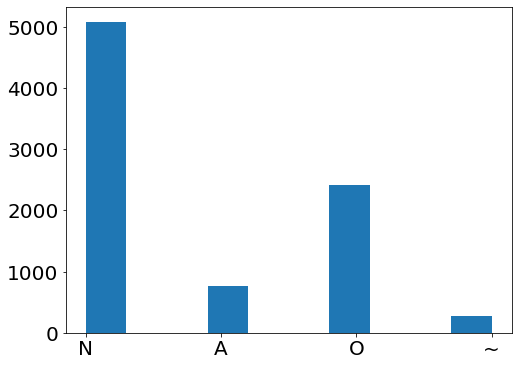

In [9]:
plt.rcParams.update({'font.size': 20})

df["classes"].hist(
    figsize=(8, 6),
    grid = False,
    bins = 10,
)
plt.xticks(range(4))
# plt.savefig('init_distri.png')
plt.show()

In [10]:
df.drop(df[df.classes == '~'].index, inplace=True)

### 2.3 Wavelet helping functions

In [11]:
def gera_filtro_MH(Escala):
  passo = 1/Escala;
  X = []
  a = -5
  X.append(a)
  while a <= 5:
    a=a+passo
    X.append(a)
  Y = []
  for i in range(0,len(X)):
    Y.append(2.1741*(1/math.sqrt(2*math.pi) * (1 - X[i]**2) * np.exp(-X[i]**2/(2))))
  return Y

In [12]:
def apply_wavelet(signal, level):
  Filtro = gera_filtro_MH(level)
  y = np.convolve(signal,Filtro)
  return y

###2.4 Aplicação da tranformada Wavelet

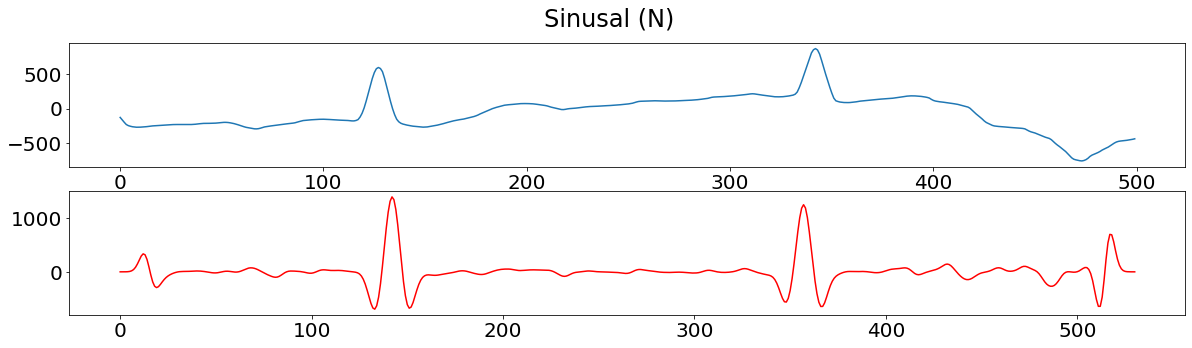

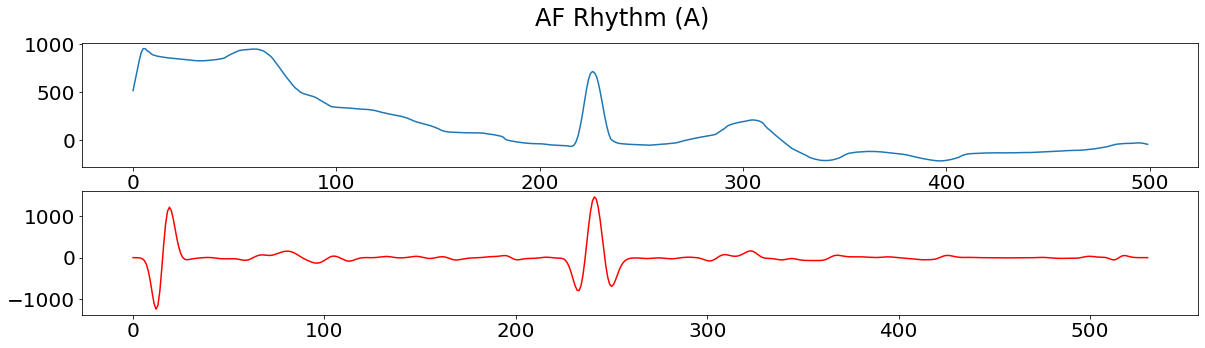

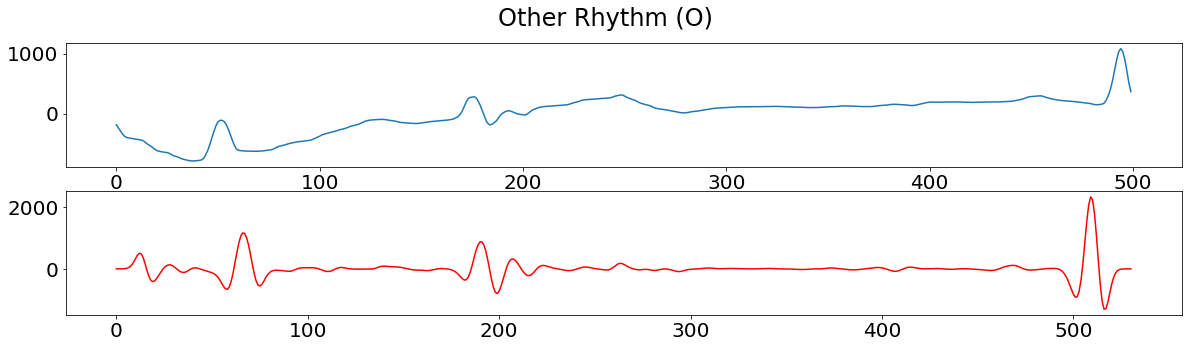

In [13]:
plt.rcParams['figure.figsize']=(20,5)

signal = df[df["classes"] == 'N'].iloc[0]["signals"][0:500]
fig, ax = plt.subplots(2,1)
fig.suptitle("Sinusal (N)")
z = apply_wavelet(signal, 3)
ax[0].plot(signal)
ax[1].plot(z, 'r')
plt.show()

signal = df[df["classes"] == 'A'].iloc[0]["signals"][0:500]
fig, ax = plt.subplots(2,1)
fig.suptitle("AF Rhythm (A)")
z = apply_wavelet(signal, 3)
ax[0].plot(signal)
ax[1].plot(z, 'r')
plt.show()

signal = df[df["classes"] == 'O'].iloc[0]["signals"][0:500]
fig, ax = plt.subplots(2,1)
fig.suptitle("Other Rhythm (O)")
z = apply_wavelet(signal, 3)
ax[0].plot(signal)
ax[1].plot(z, 'r')
plt.show()

In [14]:
x = []
for i in df["signals"]:
  val = apply_wavelet(i, 3)
  x.append(val)

In [15]:
# for i in range(0, len(x)):
#   val = zscore(x[i])
#   x[i] = val

### 2.2 Janelamento dos dados de treino

In [16]:
intersection = 100
window_size = 500
windows_array = ["max","max","max"]
classes_array = ['N', 'O', 'A']

In [17]:
def window(signal, intersection, window_size, n):
  s_size = len(signal)
  max_n = (s_size-intersection)/(window_size - intersection)
  samples = []
  
  if  n == "max" or n > max_n:
    n = max_n
    n = math.floor(n)
    
  max_begin = s_size - (n*(window_size) - (n-1)*intersection)
  init = random.randrange(max_begin)
  for i in range(0, n):
    begin = init + i*window_size - i*intersection
    end = begin + window_size
    samples.append(signal[begin:end])

  
  return samples

In [18]:
def embalance_data(df, classes_array, windows_array, intersection, window_size):

  a = df.groupby('classes')
  d_train = df.copy()
  d_train = d_train.iloc[0:0]


  idx = -1
  for i in classes_array:
    aux = []
    idx += 1

    for index, row in a.get_group(i).iterrows():
      samples = window(row["signals"], intersection, window_size,  windows_array[idx])
      
      for k in range(len(samples)):
        d_train = d_train.append({'signals': samples[k], 'classes': i}, ignore_index=True)

  return d_train

In [19]:
x_rem, x_test, y_rem, y_test = train_test_split(x, df["classes"], test_size=0.25)
x_train, x_valid, y_train, y_valid = train_test_split(x_rem, y_rem, test_size=0.1)

d_aux = pd.DataFrame({'signals': x_train, 'classes': y_train})
d_train = embalance_data(d_aux, classes_array, windows_array, intersection, window_size)

d_aux = pd.DataFrame({'signals': x_valid, 'classes': y_valid})
d_valid = embalance_data(d_aux, classes_array, windows_array, intersection, window_size)

b = d_train.groupby('classes')

for i in ['N','O', 'A']:
  print(i)
  aux = []

  for j in b.get_group(i)["signals"]:
    aux.append(len(j))

  print('Média:', round(np.mean(aux), 2))
  print("Std:", round(np.std(aux), 2))
  print("Qntd:", len(aux))
  print("Min:", min(aux))
  print("---------------")

N
Média: 500.0
Std: 0.0
Qntd: 80864
Min: 500
---------------
O
Média: 500.0
Std: 0.0
Qntd: 40544
Min: 500
---------------
A
Média: 500.0
Std: 0.0
Qntd: 12071
Min: 500
---------------


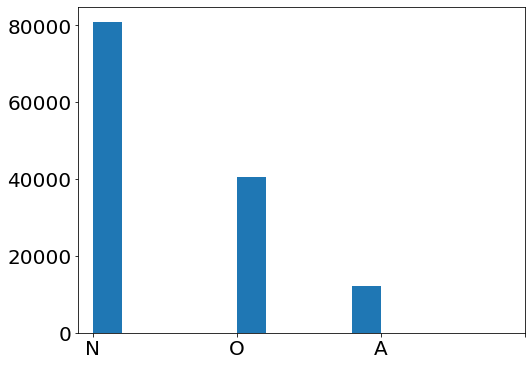

In [20]:
plt.rcParams.update({'font.size': 20})

d_train["classes"].hist(
    figsize=(8, 6),
    grid = False,
    bins = 10,
)
plt.xticks(range(4))
# plt.savefig('end_distri.png')
plt.show()

###2.4 "Normalização" do tamanho dos sinais

In [21]:
# for i in range(0, len(x)):
#   val = normalize([x[i]])
#   x[i] = val[0]

#3. Implementação da CNN

##3.1 Descoberta dos hyperparâmetros (Otimização Bayseana)

In [22]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv1D, MaxPooling1D

from keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl

In [23]:
y_train = pd.get_dummies(d_train["classes"])
y_valid = pd.get_dummies(d_valid["classes"])

x_train = list(d_train["signals"])
x_valid = list(d_valid["signals"])

x_train = np.array(x_train)
x_valid = np.array(x_valid)
x_test = np.array(x_test)

<ipython-input-23-d097fb1052ba>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test = np.array(x_test)


In [24]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
# x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], 1)

In [25]:
# Import packages
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score

pd.set_option("display.max_columns", None)

from sklearn import metrics
import tensorflow as tf

In [26]:
score_acc = make_scorer(accuracy_score)

In [27]:
len(x_train[0])

500

In [29]:
input_shape = len(x_train[0])
k1 = 5
k2 = 3
n = math.floor(input_shape/(k1+k2-2))
nn_input = input_shape % (k1+k2-2)

classificador = Sequential()

for i  in range(0, 5):
  if i == 0:
    classificador.add(Conv1D(filters=32, kernel_size = k1, input_shape = (input_shape, 1), activation = "relu"))
  else:
      classificador.add(Conv1D(filters=32, kernel_size = k1, activation = "relu"))
  # BatchNormalization()
  
  classificador.add(Conv1D(filters=64, kernel_size = k2, activation = "relu"))
  # BatchNormalization()
  # classificador.add(Conv1D(filters=32, kernel_size = k2, activation = "relu"))
  classificador.add(MaxPooling1D(pool_size=2))

classificador.add(Flatten())

classificador.add(Dense(units=64, activation='relu'))
classificador.add(Dense(units=32, activation='relu'))
classificador.add(Dense(units=16, activation='relu'))

classificador.add(Dense(3, activation="softmax"))

classificador.compile(loss='categorical_crossentropy', optimizer=Adamax(learning_rate=0.01), metrics=["accuracy"])


es = EarlyStopping(monitor="accuracy", mode='max', verbose=0, patience=15)

history = classificador.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=150, batch_size=128, callbacks=es, verbose=1)



Epoch 1/150
1043/1043 [==============================] - 26s 16ms/step - loss: 0.8305 - accuracy: 0.6362 - val_loss: 0.7491 - val_accuracy: 0.6589
Epoch 2/150
1043/1043 [==============================] - 15s 15ms/step - loss: 0.7227 - accuracy: 0.6785 - val_loss: 0.7339 - val_accuracy: 0.6637
Epoch 3/150
1043/1043 [==============================] - 15s 15ms/step - loss: 0.6963 - accuracy: 0.6948 - val_loss: 0.7137 - val_accuracy: 0.6876
Epoch 4/150
1043/1043 [==============================] - 14s 14ms/step - loss: 0.6781 - accuracy: 0.7051 - val_loss: 0.7090 - val_accuracy: 0.6923
Epoch 5/150
1043/1043 [==============================] - 14s 14ms/step - loss: 0.6652 - accuracy: 0.7126 - val_loss: 0.7219 - val_accuracy: 0.6832
Epoch 6/150
1043/1043 [==============================] - 15s 14ms/step - loss: 0.6542 - accuracy: 0.7177 - val_loss: 0.6884 - val_accuracy: 0.7022
Epoch 7/150
1043/1043 [==============================] - 15s 14ms/step - loss: 0.6466 - accuracy: 0.7209 - val_loss: 0

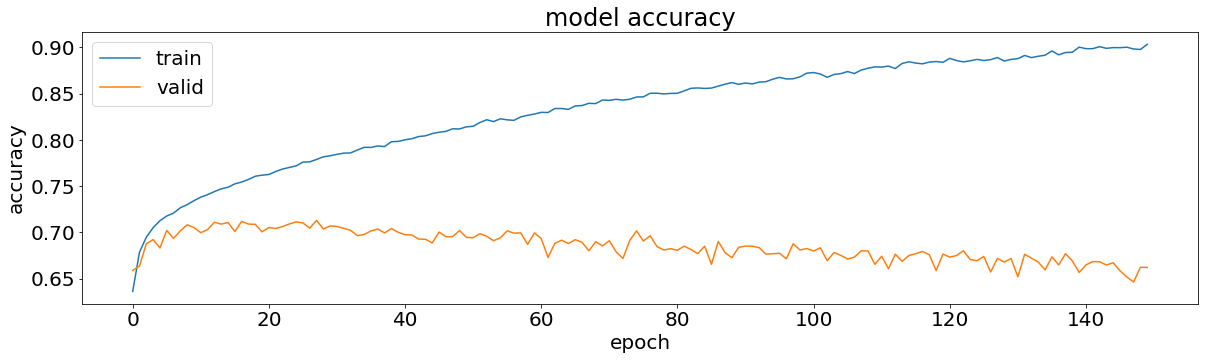

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig("history.png")
plt.show()

In [31]:
y_pred = classificador.predict(x_valid)
y_pred = pd.DataFrame(y_pred)
y_pred.columns = ['A', 'N', 'O']

465/465 [==============================] - 2s 3ms/step


In [32]:
y_valid = y_valid.idxmax(axis=1)
y_pred = y_pred.idxmax(axis=1)

In [33]:
accuracy_score(y_valid, y_pred)
# score = cross_val_score(classificador, x_valid, y_valid, scoring=score_acc, cv=5)

# media = score.mean()
# std = score.std()

0.6621121356936125

In [34]:
from sklearn.metrics import classification_report 
 
relatorio = classification_report(y_valid, y_pred) 
print(relatorio)

              precision    recall  f1-score   support

           A       0.48      0.42      0.45      1166
           N       0.75      0.78      0.77      8941
           O       0.52      0.49      0.51      4750

    accuracy                           0.66     14857
   macro avg       0.58      0.57      0.57     14857
weighted avg       0.66      0.66      0.66     14857



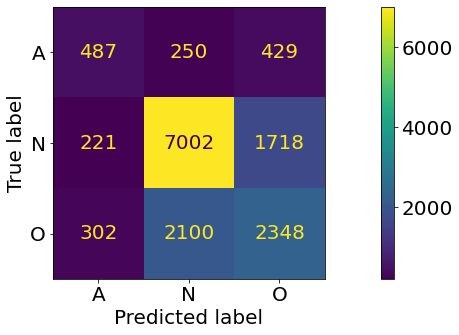

In [35]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

cf_matrix = confusion_matrix(y_valid, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = ['A', 'N', 'O'])
cm_display.plot()
plt.savefig("valid.png")

## 4. Verificando  a precisão com os dados de teste

In [36]:
y_pred = []
for signal in x_test:
  samples = window(signal, intersection, window_size, "max")
  samples = np.array(samples)
  samples = samples.reshape(samples.shape[0],samples.shape[1], 1)
  
  prediction = classificador.predict(samples)
  prediction = pd.DataFrame(prediction)
  prediction.columns = ['A', 'N', 'O']
  prediction = prediction.idxmax(axis=1)
  val = prediction.mode()[0]
  y_pred.append(val)



1/1 [==============================] - 0s 21ms/step


In [37]:
# y_pred = classificador.predict(x_test)
# y_pred = pd.DataFrame(y_pred)
# y_pred.columns = ['A', 'N', 'O', '~']

In [38]:
# y_test = y_test.idxmax(axis=1)
# # y_pred = y_pred.idxmax(axis=1)

In [39]:
accuracy_score(y_test, y_pred)
# score = cross_val_score(classificador, x_valid, y_valid, scoring=score_acc, cv=5)

# media = score.mean()
# std = score.std()

0.7653902084343189

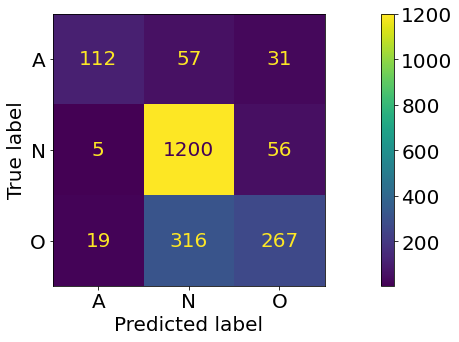

In [40]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

cf_matrix = confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = ['A', 'N', 'O'])
cm_display.plot()
plt.savefig("test.png")

In [41]:
accuracy_score(y_test, y_pred)

0.7653902084343189